In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import rdkit
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from rdkit import RDConfig
import os


In [4]:
def load_csv(CSVname):
    '''Loads the CSV files.
    CSVname should be the name of the CSV file to load inside the /1.data/ directory'''

    if isinstance(CSVname, str) == False:
        print("Error: the this instance is not a string")
        return
    elif CSVname.endswith(".csv") == False:
        print("Error: this string does not end with .csv")
        return
    path = pathlib.Path().parent.absolute()
    path = str(path) + "/1.data/" + CSVname
    try:
        df = pd.read_csv(path)
        return df
    except:
        print("This .csv file was not found in " + path)
        return

# Calling the function
drd2_df = load_csv("drd2targetmolecules.csv")


RDKit ERROR: [15:39:10] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [15:39:10] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [15:39:10] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [15:39:10] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [15:39:10] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [15:39:11] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [15:39:11] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [15:39:11] Explicit valence for atom # 9 N, 5, is greater than permitted
RDKit ERROR: [15:39:11] Explicit valence for atom # 8 N, 5, is greater than permitted
RDKit ERROR: [15:39:11] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [15:39:11] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [15:39:13] Explicit valence for atom # 9 

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,Molecule
0,MDAXKAUIABOHTD-UHFFFAOYNA-N,64964,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,C1CNCCNCCCNCCNC1,

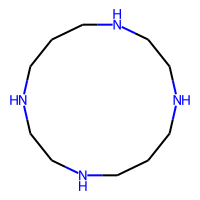

In [3]:
def molparser(df):
    '''Function to treat the dataframe (df is the input).
    First step checks if the SMILES strings of the dataframe can be parsed by rdkit.
    Second step checks for charged molecules and neutralizes their molecular structures.
    Third step checks for the presence of isomeric SMILES on the dataframe and changes them to non-isomeric.
    Forth step checks for and removes duplicates.
    Molecules that were not parsed/neutralized will be excluded from the dataframe'''

    if isinstance(df, pd.DataFrame):
        if "SMILES" in df:
            # Parsing the molecules
            PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')
            # Updates the dataframe to contain only the molecules that were parsed.
            filtered_df = df[df['Molecule'].notnull()]

            # Function for removing charges from molecules within the dataframe
            def neutralize_atoms(mol):
                pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
                at_matches = mol.GetSubstructMatches(pattern)
                at_matches_list = [y[0] for y in at_matches]
                if len(at_matches_list) > 0:
                    for at_idx in at_matches_list:
                        atom = mol.GetAtomWithIdx(at_idx)
                        chg = atom.GetFormalCharge()
                        hcount = atom.GetTotalNumHs()
                        atom.SetFormalCharge(0)
                        atom.SetNumExplicitHs(hcount - chg)
                        atom.UpdatePropertyCache()
                return mol
            # Applying the previous function to the "Molecule" column of the dataframe
            filtered_df['Molecule'] = filtered_df.Molecule.apply(neutralize_atoms)
            
            # Calculating formal charges of the molecules in the dataframe
            def calculateFormalcharge(mol):
                charge = AllChem.GetFormalCharge(mol)
                return charge
            filtered_df['FormalCharge'] = filtered_df.Molecule.apply(calculateFormalcharge)

            # Removing the molecules that have formal charges
            mask = filtered_df[filtered_df['FormalCharge'] != 0]
            N_chargedmol = len(mask)
            filtered_df = filtered_df.drop(mask.index)
            filtered_df.drop('FormalCharge', inplace=True, axis=1)
            filtered_df = filtered_df.reset_index(drop=True)
            
            # Getting the number of molecules with charge and the number of molecules with isomeric SMILES
            # Update this
            N_isoSMILES = filtered_df['SMILES'].str.count(r'@').value_counts()

            # Function to remove isomeric information from SMILES
            def getcanonicalSMILES(mol):
                canonical = rdkit.Chem.rdmolfiles.MolToSmiles(mol, isomericSmiles=False)
                return canonical
            # Updates the whole dataframe with the SMILES that do not contain isomeric information
            filtered_df['SMILES'] = filtered_df.Molecule.apply(getcanonicalSMILES)

            # Removes duplicated entries
            yesdupli = filtered_df.SMILES.count()
            filtered_df.drop_duplicates(subset=['SMILES'])
            filtered_df = filtered_df.reset_index(drop=True)
            nodupli = filtered_df.SMILES.count()

            #Information about the data:
            print("Number of entries in the input dataframe is: ", df.shape[0])
            print("Number of molecules excluded from the dataset: ", df['Molecule'].isna().sum())
            print("Number of molecules parsed by rdkit: ", df['Molecule'].notna().sum())
            print("Number of duplicated molecules in the dataset: ", (yesdupli - nodupli))
            print("Number of molecules with isomeric SMILES in the dataset:", N_isoSMILES[1])
            print("Number of molecules that could not be neutralized and were removed from the dataset:", N_chargedmol)
            print("Number of entries in the final dataframe: ", len(filtered_df))

            return filtered_df
        else:
            print("This dataframe does not contain SMILES attributes")
            return
    else:
        print("Input variable is not a dataframe")
        return

# Calling the function
drd2_df = molparser(drd2_df)


In [9]:
from rdkit import SimDivFilters
from rdkit.Chem import rdMolDescriptors

def molFPpicker(df):
    '''This function separates both actives and inactives, after
    filtering a selection using LazyBitVectorPick from RDKit'''
    
    if "Molecule" in df:
        def mol2fp(mol):
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            return fp
        df["FPs"] = df.Molecule.apply(mol2fp)
        # inactives is a pd.DataFrame with the inactive molecules (flagged N)
        inactives = df.loc[drd2_df["Activity_Flag"] == 'N']
        inactives = inactives.reset_index(drop=True)
        print('There are ', len(inactives), 'inactive entries in this data set')
        # actives is a pd.DataFrame with the active molecules (flagged A)
        activ_df = df.loc[drd2_df["Activity_Flag"] == 'A']
        activ_df = activ_df.reset_index(drop=True)
        print('There are ', len(activ_df), 'active entries in this data set')
        # Here we're preparing for sampling molecules within the inactives so we can reduce our \
        # amount of data while retaining different chemical species.
        lp = SimDivFilters.rdSimDivPickers.LeaderPicker()
        picks = lp.LazyBitVectorPick(inactives.FPs.tolist(), len(inactives), 0.65) # Thresholds of either 0.65, 0.60, 0.50 or 0.40 are the most common
        sele_inactiv_df = inactives.iloc[picks, :]
        sele_inactiv_df = sele_inactiv_df.reset_index(drop=True)
        return activ_df, sele_inactiv_df
        # This function returns the dataframe of actives and the datafarame of the selected inactives (based on the lazybitvectorpick)
    else:
        print("This dataframe does not contain the Molecules attribute... \
               Try again after executing the previous function")
        return

# Calling the function:
activ_df, sele_inactiv_df = molFPpicker(drd2_df)

In [12]:
from sklearn.model_selection import train_test_split

# Define a function that picks train test split and a test set split! Basically I want to perform the following steps within a function:
def trainprepare(actives_df, inactives_sele_df):
    '''This function gets two dataframes as input: actives and inactives.
    Then it does the training and testing splits of both actives and inactives,
    merging both to generate the output, totaltrain and totaltest.'''

    print("The amount of active molecules in your dataframe is: ", len(actives_df))
    print("The amount of inactive molecules in your dataframe is: ", len(inactives_sele_df))
    if len(actives_df) > len(inactives_sele_df):
        print("The number of molecules in your actives (first entry) dataframe is higher than your inactives (second entry).\
            Certrify yourself that this is not an error and run this code again.")
        return
        
    # split the actives dataframe:
    train_act, test_act = train_test_split(actives_df, test_size=0.3, random_state=0)
    test_act = test_act.reset_index(drop=True)
    train_act = train_act.reset_index(drop=True)

    # split the inactives dataframe:
    train_inact, test_inact = train_test_split(inactives_sele_df, test_size=0.3, random_state=0) 
    test_inact = test_inact.reset_index(drop=True)
    train_inact = train_inact.reset_index(drop=True)
    
    # concatenate both train_df and test_df dataframes
    totaltrain = pd.concat([train_act, train_inact])
    totaltrain = totaltrain.reset_index(drop=True)
    print("Total number of molecules present in the training set is: ", len(totaltrain))
    totaltest = pd.concat([test_act, test_inact])
    totaltest = totaltest.reset_index(drop=True)
    print("Total number of molecules present in the testing set is: ", len(totaltest))
    return totaltrain, totaltest

# Calling the function
train_df, test_df = trainprepare(activ_df, sele_inactiv_df)

The amount of active molecules in your dataframe is:  4606
The amount of inactive molecules in your dataframe is:  13491
Total number of molecules present in the training set is:  12667
Total number of molecules present in the testing set is:  5430


In [11]:
def arraycalculate(train_df, test_df, fingerprint):
    '''
    Takes three inputs in this order:
    
    1) Train and 2) Test dataframes generated by the trainprepare() function.
    The name of the fingerprint or molecular descriptor that we want to use in our model.
    Available fingerprints are:
    [ECFP4, ECFP6, Avalon, MACCSkeys, AP, hashAP, TT, hashTT, RDK5, RDK6, RDK7]

    This function outputs 4 np.arrays (X as fingerprints and y as the activity flags):

    1) X_train, 2) y_train
    3) X_test and 4) y_test
    '''

    if isinstance(fingerprint, str) == False:
        print("Error: the this instance is not a string")
        if fingerprint not in ["ECFP4", "ECFP6", "Avalon", "MACCSkeys", "AP", "hashAP", "TT", "hashTT", "RDK5", "RDK6", "RDK7"]:
            print("Selected fingerprints are not present in the dataframe generated by trainprepare()")
            print("Try running the function implementFPs()")
            return
        return
    
    else:
        X_train = np.asarray([np.asarray(fp) for fp in train_df['ECFP4']])
        y_train = np.asarray([1 if flag == 'A' else 0 for flag in train_df['Activity_Flag']])

        X_test = np.asarray([np.asarray(fp) for fp in test_df['ECFP4']])
        y_test = np.asarray([1 if flag == 'A' else 0 for flag in test_df['Activity_Flag']])
        return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = arraycalculate(train_df, test_df, "ECFP4")

In [48]:
def savedata(entry, filename):
    '''Saves either pandas dataframes or numpy arrays
    pd files will be saved in the 1.data directory
    np files will be saved in the 1.data/arrays/ directory
    X is used for fingerprint vectors and 
    y for the activity flag'''

    path = pathlib.Path().parent.absolute()
    path = str(path) + "/1.data/"

    if type(entry).__module__ == 'pandas.core.frame':
        if 'Molecule' in entry:
            entry.drop('Molecule', axis=1, inplace=True)
            entry.drop('FPs', axis=1, inplace=True)
        entry.to_csv(path + str(filename) + '.csv')

    elif type(entry).__module__ == 'numpy':
        path = path + "/arrays/" + str(filename)
        np.save(path, entry)

    else:
        print("Error, filetype is not supported")
        return
        
savedata(y_test, "drd2test_activ_ECFP4")

,Unnamed: 0,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,Molecule,ECFP4
0,0,VFPMJQLPEIDGKV-AQKKSAQBNA-N,25130155,1813,A,7.52578,pubchem,390631,9606,DRD2,1171,OC1(c2ccc(Cl)c(Cl)c2)CC2CCC(C1)N2Cc1csc2ccccc12,,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,CYOBJTAQBGDFGU-YPGOJHLTNA-N,CHEMBL3084524,1813,A,8.85000,chembl20,538660,9606,DRD2,1171,OC1(c2ccc(Cl)c(Cl)c2)CC2CCC(C1)N2Cc1coc2ccc(F)...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,MOXRKUZTWOCHHC-UHFFFAOYNA-N,90644075,1813,A,7.20066,pubchem,1152669,9606,DRD2,1171,O=S(=O)(NCCCN1CCN(c2noc3ccccc23)CC1)c1ccc(OC(F...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,HAJIPROMBKTILW-LQFNOIFHNA-N,CHEMBL257536,1813,A,5.00000,chembl20,465004,9606,DRD2,1171,Cc1ncoc1-c1nnc(SCCCN2CCc3cc4c(cc3CC2)OCC(=O)N4...,,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
4,4,CNGQSMFIQRDDKI-UHFFFAOYNA-N,15508240,1813,A,5.20066,pubchem,64669,9606,DRD2,1171,C#Cc1cccn1C1CCN(Cc2ccccc2)CC1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425,5425,MCQJJUIRLRNPTF-UHFFFAOYNA-N,15989173,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,CCCN(CCC)C(=O)Cn1c(=O)n(-c2ccc(OC)cc2OC)c(=O)c...,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5426,5426,INCRTJCZZQLOSX-WCTDGMBLNA-N,5458250,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,CC(=NO)C1CC(CC(=O)O)C1(C)C,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5427,5427,XLZXIIAOYZDBFY-UHFFFAOYNA-N,23608995,1813,N,NaN,pubchem_screening,485347,9606,DRD2,1171,C=Cc1ccc(Cn2nc(-c3ccccc3)ccc2=O)cc1,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5428,5428,DBMUAQNATHFVMS-UHFFFAOYNA-N,16018986,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,CC(C)n1c(=O)c2oc3ccccc3c2n(Cc2ccccc2F)c1=O,,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."

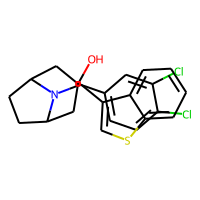
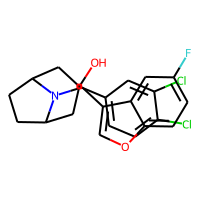
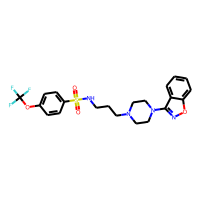
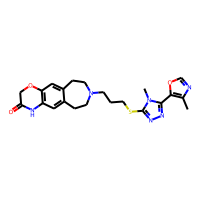
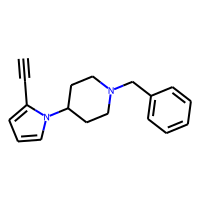
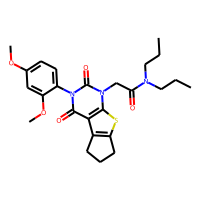
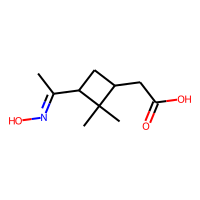
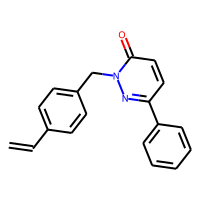
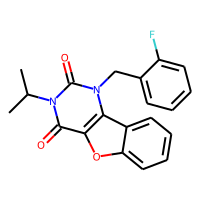
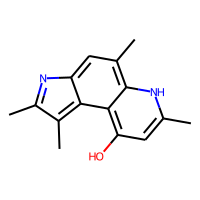

In [7]:
from rdkit import SimDivFilters
from rdkit.Chem import rdMolDescriptors
from rdkit import Avalon
from rdkit.Chem.AtomPairs import Torsions

def implementFPs(df, descriptorlist):
    '''Function that will be used to apply different fingerprints to our data set molecules '''

    if "Molecule" not in df:
        PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')
    
    if "Molecule" in df:

        #Circular fingerprints
        if "ECFP4" in descriptorlist:
            df['ECFP4'] = df.Molecule.apply(lambda mol: \
                rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)) # ECFP4
        if "ECFP6" in descriptorlist:
            df['ECFP6'] = df.Molecule.apply(lambda mol: \
                rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=1024)) # ECFP6

        # Structural fingerprints:
        if "Avalon" in descriptorlist:
        df['Avalon'] = df.Molecule.apply(lambda mol: \
            rdkit.Avalon.pyAvalonTools.GetAvalonFP(mol, nBits=1024)) # Avalon
        if "MACCSkeys" in descriptorlist:
        df['MACCSkeys'] = df.Molecule.apply(lambda mol: \
            rdkit.Chem.rdMolDescriptors.GetMACCSKeysFingerprint(mol)) #MACCS Keys
        
        # Note on the MACCS keys:
        '''Note that the MACCS key is 166-bit-long, but RDKit generates a 167-bit-long fingerprint. 
        It is because the index of a list/vector in many programming languages (including python) begins at 0.
        To use the original numbering of the MACCS keys (1-166) (rather than 0-165), the MACCS keys were 
        implemented to be 167-bit-long, with Bit 0 being always zero. Because Bit 0 is set to OFF for all compounds,
        it does not affect the evaluation of molecular similarity.'''

        # Path-based
        if "AP" in descriptorlist:
            df['AP'] = df.Molecule.apply(lambda mol: \
                rdkit.Chem.rdMolDescriptors.GetAtomPairFingerprint(mol))  # Atom pair fingerprint
        if "hashAP" in descriptorlist:
            df['hashAP'] = df.Molecule.apply(lambda mol: \
                rdkit.Chem.rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=1024))
        if "TT" in descriptorlist:
            df['TT'] = df.Molecule.apply(lambda mol: \
                Torsions.GetTopologicalTorsionFingerprintAsIntVect(mol)) # Topological torsion fingerprint
        if "hashTT" in descriptorlist:
            df['hashTT'] = df.Molecule.apply(lambda mol: \
                rdkit.Chem.rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=1024))
        if "RDK5" in descriptorlist:
            df['RDK5'] = df.Molecule.apply(lambda mol: \
                rdkit.Chem.rdmolops.RDKFingerprint(mol, maxPath=5, fpSize=1024, nBitsPerHash=2))
        if "RDK6" in descriptorlist:
            df['RDK6'] = df.Molecule.apply(lambda mol: \
                rdkit.Chem.rdmolops.RDKFingerprint(mol, maxPath=6, fpSize=1024, nBitsPerHash=2))
        if "RDK7" in descriptorlist:
            df['RDK7'] = df.Molecule.apply(lambda mol: \
                rdkit.Chem.rdmolops.RDKFingerprint(mol, maxPath=7, fpSize=1024, nBitsPerHash=2))
        return df
    
    else:
        print("The input of this function doesn't contain the parsed molecules")
        print("Try checking your dataframe. SMILES were not available")
        return

implementFPs(test_df, ["ECFP4"])


In [15]:
# Logistic Regression
# Implement this one: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

from sklearn.linear_model import LogisticRegression

clf_logrmodel = LogisticRegression(random_state=0)
clf_logrmodel.fit(X_train, y_train) # doing the training for the model
clf_logrmodel.predict(X_train)
clf_logrmodel.score(X_train, y_train)
clf_logrmodel.predict_proba(X_train)

array([[4.40859502e-03, 9.95591405e-01],
       [6.69606611e-01, 3.30393389e-01],
       [1.77544497e-02, 9.82245550e-01],
       ...,
       [9.82193240e-01, 1.78067600e-02],
       [9.99997101e-01, 2.89923479e-06],
       [9.98511798e-01, 1.48820179e-03]])

In [58]:
# Support Vector Machine
from sklearn import svm
from sklearn.svm import LinearSVC

clf_svm = LinearSVC(random_state=0)
clf_svm.fit(X_train, y_train)
clf_svm.score(X_train,y_train)


0.9973158601089445